# DS3000 Final Project: Predicting BABIP From Statcast Gamelogs

## Team 15
- Jusin Chen: chen.justi@northeastern.edu
- John Dunlevy: dunlevy.j@northeastern.edu

### Reuse Permissions
    The following may be re-used for any purposes:
    - all data included with submission
    - all images
    - this report and the notebooks which collected / cleaned the data
    - the associated [video presentation](todo:addlink)
    Please attribute any work to the authors listed above.

# Executive Summary
In this project, we predict the batting average on balls in play (BABIP) for each qualified player in the 2020 season by classifying batted ball results as hits or outs based on [Statcast](https://www.mlb.com/glossary/statcast) data about the batted ball. We classify batted balls in the 2020 season based on the results of its 3 closest batted balls from the 2019 season. Cross-validation shows that our classifier is relatively accurate, though we attempt to determine which basic statistics might contribute to differences between true and predicted BABIP. We train a Random Forest Classifier using a number of basic statistics and our BABIP classifications. Cross validation reveals that the Random Forest Classifier is inaccurate, meaning that we were not able to determing meaningful feature importances for these statistics. Our method fails to identify underlying statistics that may contribute to BABIP besides the quality of balls in play, likely due to the randomness of baseball. 

# Ethical Considerations
The rise of sabermetrics and use of advanced statistics in baseball has led to an increasing amount of free-agents left unsigned or paid less than they traditionally have been. The recent free agent markets have been very slow, like how stars Bryce Harper and Manny Machado did not sign until spring training. The reason for this is because general managers and coaches are able to analyze what player performance factors (exit velocity, spin rate, etc) are favorable for their team or overall performance and just look for players within their minor leagues to fill in roster spots of free agents. This has led to many high-profile free agents being underpaid or unemployed and more money saved by already-rich owners.

Many teams have been able to game plan to expose and magnify certain players’ weaknesses and render them ineffective. The most popular example is with former Phillie, Ryan Howard. Howard, a former Rookie of the Year and MVP was looking like a Hall of Fame lock until injuries slowed his career. After he became healthy, he was still unable to produce like he used to because teams were able to analyze his swings and tendencies, pitch to his weaknesses, and plan defensive shifts which basically ended his career https://fivethirtyeight.com/features/ryan-howards-career-is-dead-the-shift-killed-it/
.

Sabermetrics have also been able to save countless careers as coaches are able to identify players with the right skill sets (but are just not performing up to how they used to or expected). Many players have been able to revive or jumpstart their careers because coaches were able to see what they were doing with their mechanics and just fix their approach to the game. Players like these include Chris Taylor, Drew Pomeranz, and Charlie Morton. https://theathletic.com/371625/2018/05/29/long-known-as-sinkerballer-charlie-morton-finding-success-elsewhere/


# Introduction
It is a common saying in baseball that "it is better to be lucky than good". Many times throughout games and seasons, players will hit a hard line drive directly at fielders, whie soft "bloop" singles land perfectly between fielders. 

BABIP, or batting average on balls in play, is generally viewed as a measurement of a hitter’s luck. Essentially, it is the percentage of the batter's balls hit into play (excluding homeruns) that result in base hits. Because it does not include strikeouts, walks, homeruns, or other results that do not involve a ball being hit into play, requiring the fielders to make a play, it depends on a combination of a player's skill and luck in avoiding fielders. 

Thus, it is often used as a reference as to how a hitter is performing this season. If a batter's traditional statistics indicate that he is underperforming and hitting below his usual averages, BABIP may be referenced to get a sense of his luck, or lack thereof. If his BABIP is abnormally low, it could mean that the hitter is unlucky with the balls he puts into play, if not, he might have actually regressed. On the flip side, BABIP may also be used to see if a hitter is overperforming if it is high, then that hitter is having a lot of luck with balls he hits, and he might be due for regression to the mean. 

The goal is to make a model that is able to predict a hitter’s theoretical BABIP based on their Statcast metrics and also to identify if there is more than just luck involved and whether or not traditional statistics, like walks, strikeouts, and type of hits, contribute to a hitter’s BABIP.

This project will scrape statistics and game logs from [Baseball Savant](https://baseballsavant.mlb.com/) to find relationships between batted balls in play, a batted balls hit result, and the attributes of the batted balls. In particular, Statcast data about batted balls as well as statistics about the player that hit them will be used to determine the likelihood that a batted ball by a player will result in a hit. 

# Data Description

### Baseball Savant Gamelogs
We scraped Statcast Gamelog data from [Baseball Savant](https://baseballsavant.mlb.com/savant-player/mike-trout-545361?stats=gamelogs-r-hitting-statcast&season=2019&gamelogs_event=&gamelogs_direction=&gamelogs_pitchtypes=&gamelogs_view=statcastGameLogs) for each ball in play for each qualified hitter in the 2019 and 2020 Major League Baseball (MLB) seasons. See `data_collection_cleaning.ipynb` for details on the data scraping and cleaning pipeline. 

We compiled two pandas DataFrames, `df_gamelogs_2019` and `df_gamelogs_2020` containing data about each batted ball in play by qualified players in the 2019 and 2020 seasons respectively. Each entry includes:
- `exit_velo`: the exit velocity of the batted ball off the bat (mph)
- `launch_angle`: the launch angle of the batted ball off the bat (degrees)
- `player`: the batter who hit the ball
- `result`: the result of the batted ball such as `single`, `double`, `triple `, or type of out
- `hit_type`: simplified version of `result`, marks batted ball as `single`, `double`, `triple`, or `out`
- `is_hit`: 1 if batted ball was a hit, 0 otherwise

In [1]:
import pandas as pd
import numpy as np

df_gamelogs_2019 = pd.read_csv('gamelogs2019.csv')
del df_gamelogs_2019['Unnamed: 0']
df_gamelogs_2020 = pd.read_csv('gamelogs2020.csv')
del df_gamelogs_2020['Unnamed: 0']

In [2]:
df_gamelogs_2019.head()

,exit_velo,launch_angle,player,result,hit_type,is_hit
0,87.6,13.0,Albert Pujols,single,single,1
1,84.7,44.0,Albert Pujols,field_out,out,0
2,99.4,28.0,Albert Pujols,field_out,out,0
3,95.3,17.0,Albert Pujols,field_out,out,0
4,84.8,-40.0,Albert Pujols,field_out,out,0


In [3]:
df_gamelogs_2020.head()

,exit_velo,launch_angle,player,result,hit_type,is_hit
0,69.9,49.0,David Peralta,field_out,out,0
1,62.8,36.0,David Peralta,field_out,out,0
2,91.4,7.0,David Peralta,single,single,1
3,43.4,16.0,David Peralta,field_out,out,0
4,112.1,16.0,David Peralta,double,double,1


#### Visualizing Game Log Results
To visualize the Statcast game log data scraped from Baseball Savant, we produce two scatter plots for each DataFrame. The first plots `exit_velo` on the x-axis and `launch_angle` on the y-axis for each batted ball that resulted in an out. Then, in order to visualize patterns in `exit_velo` and `launch_angle` for all `hit_types`, we plot each batted ball, color coded by `hit_type`. 

The `plot_la_ev_by_hit_type` function takes in a DataFrame and plots each of the scatter plots on adjacent subplots. 

In [4]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_la_ev_by_hit_type(df_gamelogs, year):
    ''' Produces two scatter plots of launch angle vs. exit velocity in the given dataframe for the given
    year, one containing just outs, and the other containing all hit types
    
    Args:
        df_gamelogs (pd.DataFrame): contains statcast game log data about all batted ball events by qualified hitters
            in a single season 
        year (str): the year in which the gamelogs were collected
    
    Returns: 
        none 
    
    '''
    # Reset figure 
    plt.figure() 
    
    # Boolean mapping to extract different hit results
    bool_single = df_gamelogs['result'] == 'single'
    bool_double = df_gamelogs['result'] == 'double'
    bool_triple = df_gamelogs['result'] == 'triple'
    bool_out =  (df_gamelogs['result'] != 'single') & (df_gamelogs['result'] != 'double') & (df_gamelogs['result'] != 'triple')

    df_singles = df_gamelogs.loc[bool_single,:]
    df_doubles = df_gamelogs.loc[bool_double,:]
    df_triples = df_gamelogs.loc[bool_triple,:]
    df_outs = df_gamelogs.loc[bool_out,:]

    # On top subplot, scatter launch angle vs. exit velocity for only outs
    plt.subplot(2, 1, 1)
    plt.scatter(x=df_outs['exit_velo'], y=df_outs['launch_angle'], label='out', alpha=.4)
   
    # Set title and label axes
    plt.gca().title.set_text(f'Batted Outs in {year} season')
    plt.xlabel('exit velocity (mph)')
    plt.ylabel('launch angle (degrees)') 
    
    # On bottom subplot, scatter launch angle vs. exit velocity for each type of result 
    plt.subplot(2, 1, 2)
    plt.scatter(x=df_outs['exit_velo'], y=df_outs['launch_angle'], label='out', alpha=.4)
    plt.scatter(x=df_singles['exit_velo'], y=df_singles['launch_angle'], label='single', alpha=.4)
    plt.scatter(x=df_doubles['exit_velo'], y=df_doubles['launch_angle'], label='double', alpha=.5, color='y')
    plt.scatter(x=df_triples['exit_velo'], y=df_triples['launch_angle'], label='triple', alpha=.6)
   
    # Set title and label axes
    plt.gca().title.set_text(f'All Batted Balls in {year} season by Result')
    plt.xlabel('exit velocity (mph)')
    plt.ylabel('launch angle (degrees)') 

    # Include legend and set fiture size
    plt.legend()
    plt.gcf().set_size_inches(12, 24)
    
    # Print plot to pdf
    file = f'scatter_ev_la_true_by_hit_type_{year}.pdf'
    with PdfPages(file) as pdf:
        pdf.savefig(bbox_inches='tight')

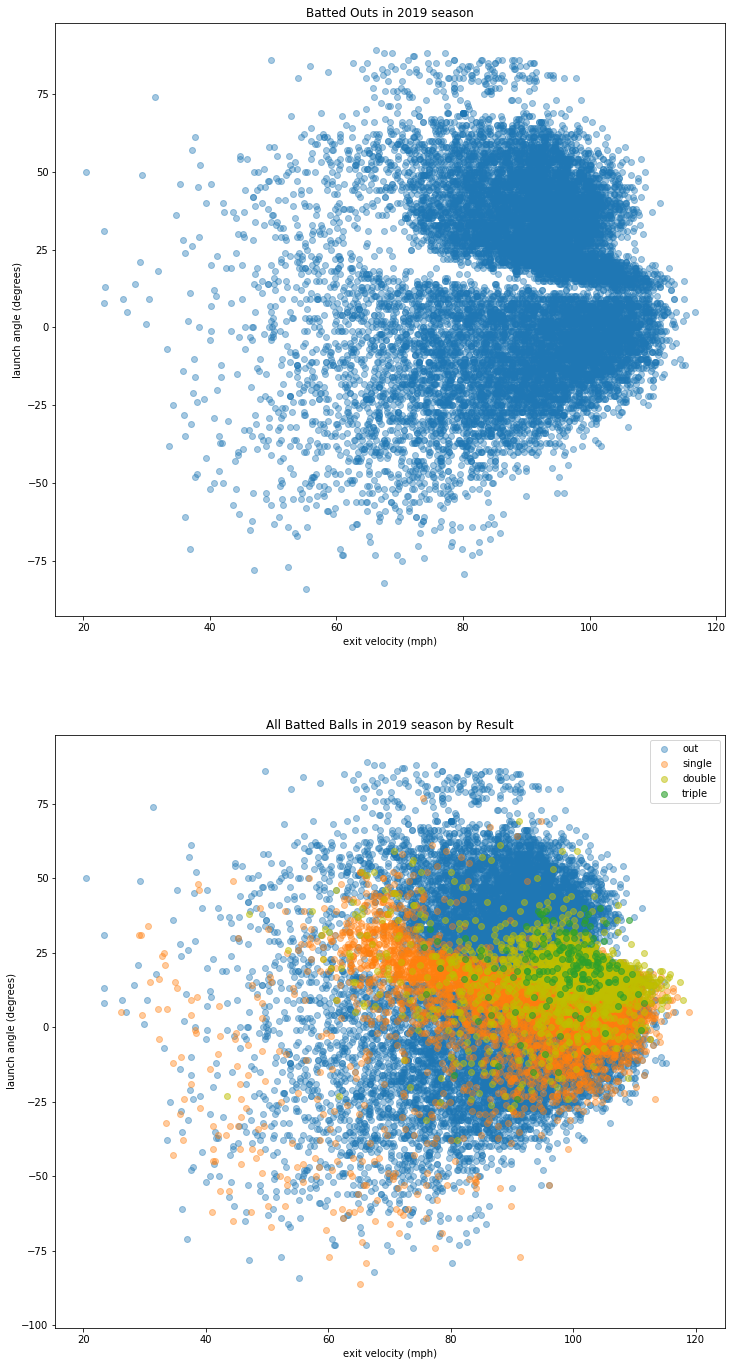

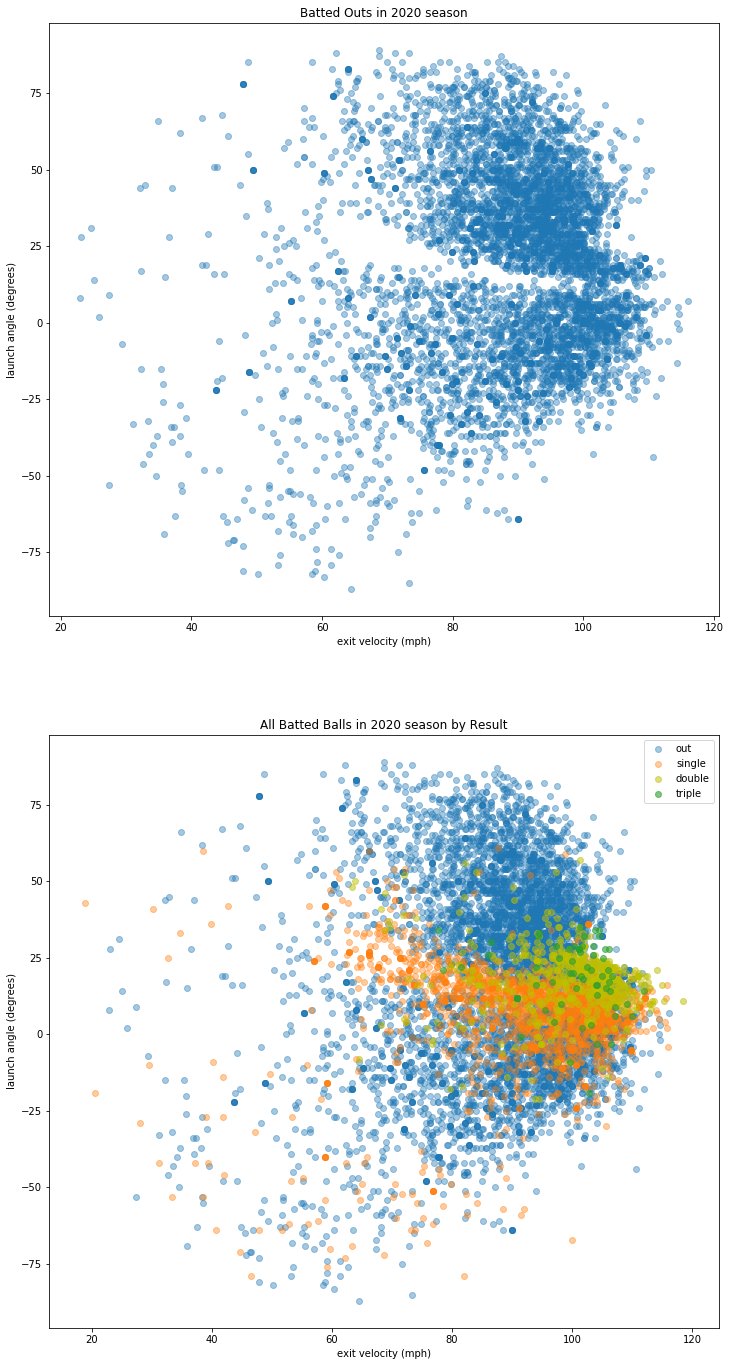

In [5]:
# Map game log data to season
gamelogs_dict = {'2019': df_gamelogs_2019, 
                 '2020': df_gamelogs_2020}

# Call plot_la_ev_by_hit_type to produce scatter plots for both seasons
for year, gamelogs in gamelogs_dict.items():
    plot_la_ev_by_hit_type(gamelogs, year)

## Basic Statistics for 2020 Season
In `data_collection_cleaning.ipynb`, [basic statistics](https://baseballsavant.mlb.com/leaderboard/custom?year=2020&type=batter&filter=&sort=4&sortDir=desc&min=50&selections=xba,xslg,xwoba,xobp,xiso,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,&chart=false&x=xba&y=xba&r=no&chartType=beeswarm) for the 2020 season were downloaded from Baseball Savant in order to calculate each player's BABIP. A variety of statistics are included for each qualified hitter. Some of these statistics, such as hits, homeruns, at-bats, homeruns, strikeouts, and sacrifice-flies, were used to calculate BABIP. 

Once BABIP was calculated for each player, it was added as a column in the DataFrame and saved to `basic_2020_babip.csv`. This `babip` column will be used to compare predicted BABIPs for each player to his actual BABIP in the 2020 season. 


In [6]:
# Read basic_2020_babip.csv, which contains each qualified hitter's BABIP for the 2020 season
df_basic_2020 = pd.read_csv('basic_2020_babip.csv')
del df_basic_2020['Unnamed: 0']
df_basic_2020.head()

,player_id,year,player_age,b_ab,b_total_pa,b_total_hits,b_single,b_double,b_triple,b_home_run,...,woba,xwoba,xobp,xiso,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,name,mlb_id,babip
0,444482,2020,33,203,218,61,45,10,1,5,...,0.333,0.295,0.301,0.110,89.2,6.4,5.0,David Peralta,444482,0.361290
1,467793,2020,34,206,255,41,26,7,0,8,...,0.316,0.368,0.390,0.194,88.0,12.2,6.7,Carlos Santana,467793,0.211538
2,488726,2020,33,170,187,51,31,15,0,5,...,0.362,0.325,0.327,0.153,88.7,10.2,4.9,Michael Brantley,488726,0.335766
3,500871,2020,31,203,222,43,29,7,3,4,...,0.257,0.305,0.316,0.132,88.6,18.1,5.5,Eduardo Escobar,500871,0.243750
4,503556,2020,31,175,199,37,28,4,0,5,...,0.269,0.314,0.315,0.162,89.2,12.6,5.1,Marwin Gonzalez,503556,0.240602


## Custom Statistics for 2020 Season
The Fangraphs [custom leaderboard feature](https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2020&month=0&season1=2020&ind=0) was used to construct a table containing a customized list of advanced statistics which will be used to analyze relationships between a player's tendencies and his likelihood to over or under perform with respect to his estimated BABIP. In particular, the data set contains underlying statistics that are not directly related to BABIP such as:
- `BB%`: walk rate (walks per plate appearance)
- `K%`: strikeout rate (strikeouts per plate appearance)
- `LD%`: line drive percentage (line drives per balls in play)
- `FB%`: fly ball percentage (fly balls per balls in play)
- `GB%`: ground ball percentage (ground balls per balls in play)
- `HR/FB`: home run to fly ball ratio (homeruns per fly balls) 
- and more

In [7]:
df_custom_2020 = pd.read_csv('custom_stats_qual_2020.csv')
df_custom_2020.head()

,Unnamed: 0,index,Name,Team,G,PA,HR,R,RBI,SB,...,IFH%,BUH%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,playerid
0,0,7,Juan Soto,WSN,47,196,13,39,37,6,...,6.2%,0.0%,92.1,4.2,22.0,0.175,113.3,65.0,51.6%,20123
1,1,11,Freddie Freeman,ATL,60,262,13,51,53,2,...,5.4%,0.0%,92.4,17.2,26.0,0.147,109.3,96.0,54.2%,5361
2,2,12,Marcell Ozuna,ATL,60,267,18,38,56,0,...,3.2%,0.0%,93.0,16.4,26.0,0.154,115.6,91.0,53.8%,10324
3,3,16,DJ LeMahieu,NYY,50,216,10,41,27,3,...,4.0%,0.0%,91.3,2.3,5.0,0.029,109.5,80.0,45.7%,9874
4,4,22,Jose Ramirez,CLE,58,254,17,45,46,10,...,11.3%,100.0%,88.7,23.2,18.0,0.102,114.3,62.0,35.0%,13510


# Method

## 3-NN Classifier
In order to predict BABIP fron individual game logs, we need to classify each batted ball as a hit or an out. From the scatter plots of `exit_velo` and `launch_angle` by hit type, we see that hits tend to cluster together, approximately in the range of `exit_velo`s from 60-120 mph, with `launch_angles` from -10 to 25 degrees. Thus, we attempt to classify batted balls based on the results of its 3 nearest neighbors in terms of `exit_velo` and `launch_angle`, as we assume that hits with similar exit velocities and launch angles will likely have similar results. 

We will first assess the viability of the 3-NN Classifier model to correctly classify unseen batted balls with 10-fold cross validation on 2019 batted ball data. If we determine the model to be appropriate, we will train a 3-NN classifier on all 2019 batted ball results, and use the resulting classifier to predict the results of each 2020 batted ball results. 

Using the predicted classifications, we will be able to predict the BABIP for each player with the formula: 
$$(# of batted balls in play classified as hits) / (total # of batted balls in play)$$



## Random Forest Classifier

Once BABIP has been predicted for each player in 2020, we are able to classify players into 3 groups by comparing their predicted BABIP to their true BABIP in 2020. The groups will include players who had a significantly higher true babip than their predicted BABIP, players who had a significantly lower true babip, and players with no significant difference between their true and predicted BABIP. 

These classifications will be matched with the corresponding player's custom statistics listed above in orderr to train a Random Forest Classifier that will use the custom statistics to attempt to classify players as likely to over perform, under perform, or perform as expected with respect to their true and predicted BABIPs. If successful, the classifier will be used to determine feature importance to tell us which custom statistic features are most important in classifying players. 

# Results

## K Nearest Neighbors
Below, we perform 10-fold cross validation on the 3-NN Classifier with 2019 game logs data. This is to determine the classifier's accuracy when classifying unseen data. 

We plot a confusion matrix to assess the accuracy of the model by totaling the number of correct classifications of hits, correct classification of outs, incorrect classification of hits, and incorrect classification of outs. These totals will be used to find the rate at which the model correctly classifies a batted ball result. 

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

# Set x features (exit velo, launch angle) and y feature (is_hit)
x_feat_list = ['exit_velo', 'launch_angle']
y_feat = 'is_hit'

# 3 Nearest neighbors, 10 fold cross validation 
k = 3
n_splits = 10

# Extract features from 2019 gamelogs
x = df_gamelogs_2019.loc[:, x_feat_list].values
y_true = df_gamelogs_2019.loc[:, y_feat].values

# Initialize classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Create Stratified 10-fold object
kfold = StratifiedKFold(n_splits=n_splits)

# Initialize an empty array same size as y_true to store predictions
y_pred = np.empty_like(y_true)

# Cross validate 
for train_idx, test_idx in kfold.split(x, y_true):
    # Get training data
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]

    # get testing data
    x_test = x[test_idx, :]
    y_true_test = y_true[test_idx]

    # train on training data
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:

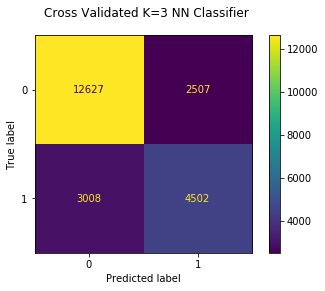

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute confusion matrix
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

# plot confusion matrix
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

sns.reset_orig()
conf_mat_disp.plot()
plt.suptitle(f'Cross Validated K={k} NN Classifier')
plt.show()

From the confusion matrix, we calculate the overall accuracy of the classifier for all results, as well as its accuracy in classifying outs and hits specifically. 

In [10]:
# Compute accuracy of 3 Nearest Neighbors Classifier 
accuracy = np.diag(conf_mat).sum() / conf_mat.sum()
print(f'Accuracy of 3 Nearest Neighbors Classifier: {accuracy}')

# Compute accuracy in classifying outs
out_accuracy = conf_mat[0][0]/conf_mat[0].sum()
print(f'Accuracy of 3-NN Classifier when classifying outs: {out_accuracy}')
      
# Compute accuracy in classifying hits
hit_accuracy = conf_mat[1][1]/conf_mat[1].sum()
print(f'Accuracy of 3-NN Classifier when classifying outs: {hit_accuracy}')

Accuracy of 3 Nearest Neighbors Classifier: 0.7564476240946829
Accuracy of 3-NN Classifier when classifying outs: 0.8343465045592705
Accuracy of 3-NN Classifier when classifying outs: 0.5994673768308921


The league average BABIP is [usually around .300](https://www.mlb.com/glossary/advanced-stats/babip#:~:text=The%20league%20average%20BABIP%20is,the%20mean%2C%20and%20vice%20versa). As a sanity check, we make sure that our 3 Nearest Neighbors Classifier classifies about 30% of batted ball events as base hits. 

In [11]:
# Compute predicted league average babip as predicted by our 3 NN classifier
predicted_league_babip = (conf_mat[0][1] + conf_mat[1][1]) / conf_mat.sum()
print(f'Predicted leage average babip: {predicted_league_babip}')

Predicted leage average babip: 0.30953011835364774


## Estimating BABIP

After cross validating our 3 Nearest Neighbors Classifier, we train a classifier on all 2019 batted ball events. This classifier will then be used to predict the babips for each qualified player in the 2020 season. 

In [12]:
# Set x features (exit velo, launch angle) and y feature (is_hit)
x_feat_list = ['exit_velo', 'launch_angle']
y_feat = 'is_hit'

# Extract features from 2019 gamelogs
x_2019 = df_gamelogs_2019.loc[:, x_feat_list].values
y_true_2019 = df_gamelogs_2019.loc[:, y_feat].values

# Create and train a 3-NN classifier on all 2019 data 
knn_classifier_2019 = KNeighborsClassifier(n_neighbors=3)
knn_classifier_2019.fit(x_2019, y_true_2019)

KNeighborsClassifier(n_neighbors=3)

In [13]:
# Extract exit velo and launch angle data from 2020 to be classified
x_pred_2020 = df_gamelogs_2020.loc[:, x_feat_list].values
y_true_2020 = df_gamelogs_2020.loc[:,'is_hit'].values

y_pred_2020 = knn_classifier_2019.predict(x_pred_2020)


In [14]:
# Add predictions to df_gamelogs_2020
df_gamelogs_2020['pred_hit_type'] = y_pred_2020

# Add column showing if prediction and actual result are the same
df_gamelogs_2020['correct_pred'] = df_gamelogs_2020['is_hit'] == df_gamelogs_2020['pred_hit_type']

### Analyzing Predicted Results
- In order to analyze the accuracy of predicted results, we will plot a confusion matrix displaying the counts for each true result and prediction pair. 
- We will then visualize the results in order to see how batted balls were classified, and where incorrect predictions.  

/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:

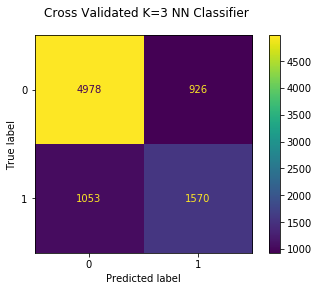

In [15]:
# Create and plot confusion matrix to display how many predictions were
# correct or incorrect

# compute confusion matrix
conf_mat_2020 = confusion_matrix(y_true=y_true_2020, y_pred=y_pred_2020)

# plot confusion matrix
conf_mat_disp = ConfusionMatrixDisplay(conf_mat_2020, display_labels=np.unique(y_true))

sns.reset_orig()
conf_mat_disp.plot()
plt.suptitle(f'Cross Validated K={k} NN Classifier')
plt.show()

Again, we compute the accuracy and total BABIP for the classifications of 2020 batted ball results on the 3-NN Classifier trained on 2019 game log data. 

In [16]:
# Compute accuracy of 3 Nearest Neighbors Classifier 
accuracy = np.diag(conf_mat_2020).sum() / conf_mat_2020.sum()
print(f'Accuracy of 2020 Classifications: {accuracy}')

# Compute accuracy in classifying outs
out_accuracy = conf_mat_2020[0][0]/conf_mat_2020[0].sum()
print(f'Accuracy of 2020 Classifications (outs only): {out_accuracy}')
      
# Compute accuracy in classifying hits
hit_accuracy = conf_mat_2020[1][1]/conf_mat_2020[1].sum()
print(f'Accuracy of 2020 Classifications (hits only): {hit_accuracy}')

Accuracy of 2020 Classifications: 0.7679136859387827
Accuracy of 2020 Classifications (outs only): 0.8431571815718157
Accuracy of 2020 Classifications (hits only): 0.5985512771635532


In [17]:
# Compute predicted league average babip in 2020 as predicted by our 3 NN classifier
predicted_league_babip = (conf_mat_2020[0][1] + conf_mat_2020[1][1]) / conf_mat_2020.sum()
print(f'Predicted leage average babip: {predicted_league_babip}')

Predicted leage average babip: 0.29271725108478946


#### Visualize Predicted Results:

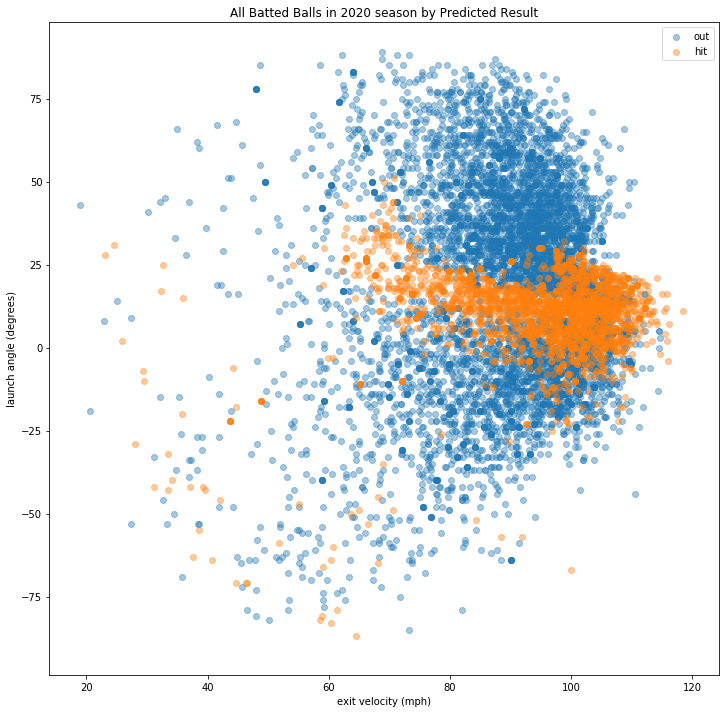

In [18]:
# Get results by hit type
bool_pred_hit = df_gamelogs_2020['pred_hit_type'] == 1
df_gamelogs_2020_pred_hit = df_gamelogs_2020.loc[bool_pred_hit,:]

bool_pred_out = df_gamelogs_2020['pred_hit_type'] == 0
df_gamelogs_2020_pred_out = df_gamelogs_2020.loc[bool_pred_out,:]

# Scatter outs by exit_velo and launch_angle
plt.scatter(x=df_gamelogs_2020_pred_out['exit_velo'], 
            y=df_gamelogs_2020_pred_out['launch_angle'],
            label='out', alpha=.4)

# Scatter hits by exit_velo and launch_angle
plt.scatter(x=df_gamelogs_2020_pred_hit['exit_velo'], 
            y=df_gamelogs_2020_pred_hit['launch_angle'],
            label='hit', alpha=.4)

# Set title and label axes
plt.gca().title.set_text(f'All Batted Balls in 2020 season by Predicted Result')
plt.xlabel('exit velocity (mph)')
plt.ylabel('launch angle (degrees)') 

# Include legend and set fiture size
plt.legend()
plt.gcf().set_size_inches(12, 12)

# Print plot to pdf
file = f'scatter_ev_la_by_predicted_hit_type_2020.pdf'
with PdfPages(file) as pdf:
    pdf.savefig(bbox_inches='tight')


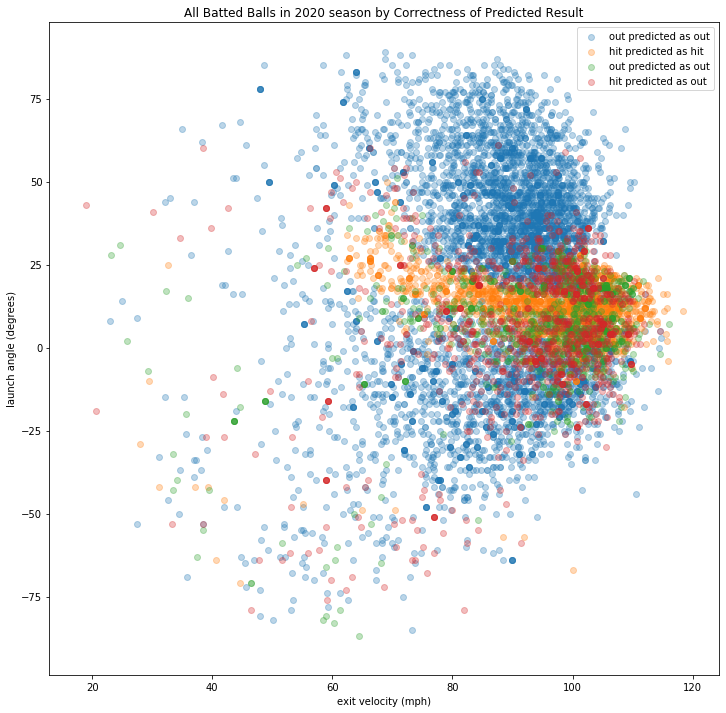

In [19]:
# Get results by correct/incorrect prediction
# Correctly predicted 

bool_pred_correct = df_gamelogs_2020['correct_pred'] == True
df_gamelogs_2020_correct = df_gamelogs_2020.loc[bool_pred_correct,:]

# Get correclty predicted hits
bool_pred_correct_hit = df_gamelogs_2020_correct['is_hit'] == 1
df_gamelogs_2020_correct_hit = df_gamelogs_2020_correct.loc[bool_pred_correct_hit,:]

# Get correctly predicted outs
bool_pred_correct_out = df_gamelogs_2020_correct['is_hit'] == 0
df_gamelogs_2020_correct_out = df_gamelogs_2020_correct.loc[bool_pred_correct_out,:]


# Incorrectly predicted
bool_pred_incorrect = df_gamelogs_2020['correct_pred'] == False
df_gamelogs_2020_incorrect = df_gamelogs_2020.loc[bool_pred_incorrect,:]

# Get incorrectly predicted hits
bool_pred_incorrect_hit = df_gamelogs_2020_incorrect['is_hit'] == 1
df_gamelogs_2020_incorrect_hit = df_gamelogs_2020_incorrect.loc[bool_pred_incorrect_hit,:]

# Get incorrectly predicted outs
bool_pred_incorrect_out = df_gamelogs_2020_incorrect['is_hit'] == 0
df_gamelogs_2020_incorrect_out = df_gamelogs_2020_incorrect.loc[bool_pred_incorrect_out,:]



# Scatter each type of prediction for each hit type

# Scatter outs predicted as outs
plt.scatter(x=df_gamelogs_2020_correct_out['exit_velo'], 
            y=df_gamelogs_2020_correct_out['launch_angle'],
            label='out predicted as out', alpha=.3)

# Scatter hits predicted as hits
plt.scatter(x=df_gamelogs_2020_correct_hit['exit_velo'], 
            y=df_gamelogs_2020_correct_hit['launch_angle'],
            label='hit predicted as hit', alpha=.3)

# Scatter outs predicted as hits
plt.scatter(x=df_gamelogs_2020_incorrect_out['exit_velo'], 
            y=df_gamelogs_2020_incorrect_out['launch_angle'],
            label='out predicted as out', alpha=.3)

# Scatter hits predicted as outs
plt.scatter(x=df_gamelogs_2020_incorrect_hit['exit_velo'], 
            y=df_gamelogs_2020_incorrect_hit['launch_angle'],
            label='hit predicted as out', alpha=.3)


# Set title and label axes
plt.gca().title.set_text(f'All Batted Balls in 2020 season by Correctness of Predicted Result')
plt.xlabel('exit velocity (mph)')
plt.ylabel('launch angle (degrees)') 

# Include legend and set fiture size
plt.legend()
plt.gcf().set_size_inches(12, 12)

# Print plot to pdf
file = f'scatter_correct_incorrect_2020.pdf'
with PdfPages(file) as pdf:
    pdf.savefig(bbox_inches='tight')

### Predicting BABIP for 2020 Players
Using the 3-NN Classifier trained on 2019 gamelogs, we predict results for each batted ball in the 2020 season for all qualified hitters. By dividing the total number of classified hits by the total number of batted ball results, we can calculate each player's predicted BABIP. 

In [20]:
def predict_babip(df_player, player, knn_clf):
    ''' Estimates the given player's batting average on balls in play 
    given his batted ball game logs and a k nearest neighbors classifier
    
    Args:
        df_player (pd.DataFrame): batted ball game logs for the player's 2019 season
        player (str): player's name 
        knn_clf (sklearn.neighbors._classification.KNeighborsClassifier): 
            knn classifier that classifies batted ball events as a hit or an out based on 
            exit velocity and launch angle 
    Returns:
        babip (float): player's batting average on balls in play 
    
    
    '''
    
    # List of features
    x_feat_list = ['exit_velo', 'launch_angle']
    
    # Extract features
    x_pred = df_player.loc[:, x_feat_list].values
    y_true = df_player.loc[:, 'is_hit'].values
    
    # Predict batted ball results for the given player
    y_pred = knn_clf.predict(x_pred)
    
    # Compute babip
    babip = y_pred.sum() / len(y_pred)
    
    return babip 
        

In [21]:
# Get list of qualified hitters in 2020
players_2020 = df_gamelogs_2020['player'].unique()

# Initial empty dict
pred_babip_dict = {}

for player in players_2020:
    # Boolean mapping to get current player's batted ball events
    bool_player = df_gamelogs_2020['player'] == player
    df_player = df_gamelogs_2020.loc[bool_player,:]
    
    # Compute the player's babip 
    player_babip = predict_babip(df_player, player, knn_classifier_2019)
    
    # Add the player, babip to dictionary
    pred_babip_dict[player] = player_babip

In [22]:
pred_babip_dict

{'David Peralta': 0.3548387096774194,
 'Carlos Santana': 0.2830188679245283,
 'Michael Brantley': 0.22033898305084745,
 'Eduardo Escobar': 0.3088235294117647,
 'Marwin Gonzalez': 0.2682926829268293,
 'Cesar Hernandez': 0.32857142857142857,
 'Freddie Freeman': 0.5,
 'DJ LeMahieu': 0.3787878787878788,
 'Jesus Aguilar': 0.234375,
 'Brandon Crawford': 0.26,
 'Aaron Hicks': 0.3137254901960784,
 'Marcus Semien': 0.34285714285714286,
 'Mike Trout': 0.2708333333333333,
 'Bryce Harper': 0.2894736842105263,
 'Max Muncy': 0.24074074074074073,
 'Wil Myers': 0.375,
 'AJ Pollock': 0.2413793103448276,
 'Corey Dickerson': 0.25,
 'Mike Yastrzemski': 0.27450980392156865,
 'Colin Moran': 0.32432432432432434,
 'Whit Merrifield': 0.3918918918918919,
 'Jorge Polanco': 0.3333333333333333,
 'Adam Duvall': 0.3023255813953488,
 'Javier Baez': 0.2727272727272727,
 'Francisco Lindor': 0.3076923076923077,
 'Trevor Story': 0.3389830508474576,
 'Tommy La Stella': 0.2328767123287671,
 'Renato Nunez': 0.30303030303030

After predicting each player's BABIP, we observe the mean, maximum, and minimun values for the predicted BABIPs in order to compare to true babips. We observe that the mean BABIP is below the true league average of around .300, and our maximum and min values are more extreme than those of the true BABIPs.

In [23]:
babip_list_pred = list(pred_babip_dict.values())
babip_mean_pred = np.mean(babip_list_pred)
babip_max_pred = np.max(babip_list_pred)
babip_min_pred = np.min(babip_list_pred)

print('Predicted BABIPs:')
print(f'mean: {babip_mean_pred}')
print(f'max: {babip_max_pred}')
print(f'min: {babip_min_pred}')


babip_list_true = np.array(df_basic_2020['babip'])
babip_mean_true = np.mean(babip_list_true)
babip_max_true = np.max(babip_list_true)
babip_min_true = np.min(babip_list_true)
print()
print('True BABIPS:')
print(f'mean: {babip_mean_true}')
print(f'max: {babip_max_true}')
print(f'min: {babip_min_true}')

Predicted BABIPs:
mean: 0.29181277749100304
max: 0.5084745762711864
min: 0.14285714285714285

True BABIPS:
mean: 0.3015740866833346
max: 0.4117647058823529
min: 0.20300751879699247


After predicting each player's 2020 BABIP, we construct a new DataFrame to contain the true and predicted BABIP for each qualified player during the 2020 season. 

In [24]:
# Construct new DataFrame to contain true and predicted BABIPS for 2020
# Add players and their predicted BABIPs
df_pred_babip_pa = pd.DataFrame(); 
df_pred_babip_pa['player'] = pred_babip_dict.keys()
df_pred_babip_pa['pred_babip'] = pred_babip_dict.values()

In [25]:
# Dictionaries to contain player, true babip, and player plate appearances pairs
player_babip_dict = {}
player_pa_dict = {}

for idx, player in df_pred_babip_pa.iterrows():
    # Get current player's name
    name = player['player']
    
    # Boolean mapping to get current player's basic 2020 statistics
    bool_is_player = df_basic_2020['name'] == name
    player_basic = df_basic_2020.loc[bool_is_player,:]
    
    # Get player's babip and number of plate appearances
    player_babip = player_basic.iloc[0,:]['babip']
    player_pa = player_basic.iloc[0,:]['b_total_pa']
    
    # Add pairs to dictionaries
    player_pa_dict[name] = player_pa
    player_babip_dict[name] = player_babip

In [26]:
# Add dictionries constructed in the previous script to df_pred_babip_pa
df_pred_babip_pa['true_babip'] = player_babip_dict.values()
df_pred_babip_pa['pa'] = player_pa_dict.values()
df_pred_babip_pa

,player,pred_babip,true_babip,pa
0,David Peralta,0.354839,0.361290,218
1,Carlos Santana,0.283019,0.211538,255
2,Michael Brantley,0.220339,0.335766,187
3,Eduardo Escobar,0.308824,0.243750,222
4,Marwin Gonzalez,0.268293,0.240602,199
...,...,...,...,...
137,J.T. Realmuto,0.181818,0.307018,195
138,J.D. Martinez,0.240000,0.258503,237
139,Josh Bell,0.227273,0.272727,223
140,J.D. Davis,0.391304,0.317829,229


#### Plot Histogram showing distributions of predicted and true BABIPs

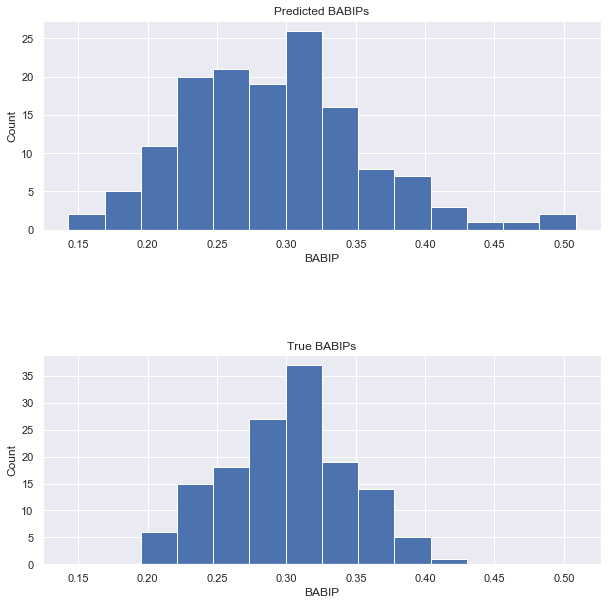

In [27]:
sns.set(font_scale=1)

bins = np.linspace(babip_min_pred, babip_max_pred, 15)

# Predicted BABIP histogram
plt.subplot(2,1,1)
plt.hist(df_pred_babip_pa['pred_babip'], bins=bins)

# Set title, label axes
plt.gca().title.set_text('Predicted BABIPs')
plt.ylabel('Count')
plt.xlabel('BABIP')

# True BABIP histogram
plt.subplot(2,1,2)
plt.hist(df_pred_babip_pa['true_babip'], bins=bins)
# Set title, label axes
plt.gca().title.set_text('True BABIPs')
plt.ylabel('Count')
plt.xlabel('BABIP')

plt.subplots_adjust(wspace = .4, hspace = .6)
plt.gcf().set_size_inches(10, 10)

# Print plot to pdf
file = f'predicted_babip_hist_2020.pdf'
with PdfPages(file) as pdf:
    pdf.savefig(bbox_inches='tight')

The histograms above give a more thorough visualization of how the predicted BABIPs compare to the true BABIPs for the 2020 season. We notice that both collections have relatively normal distributions, but our predicted BABIPs are lower on average, have more variation, and a higher range.  

### Percent Difference between True and Expected BABIP
We now compute the percent difference between the True and Expected BABIP for each qualified player in 2020. These values will be used to classify players as performing above, below, or at expectations when comparing their actual BABIP to their true BABIP.  

In [28]:
# Produce pandas series containing percent differences between predicted and true BABIP
pct_diff_babip = (df_pred_babip_pa['pred_babip'] - df_pred_babip_pa['true_babip']) / df_pred_babip_pa['true_babip']

# Add percent differences as a column in df_pred_babip_pa
df_pred_babip_pa['pct_diff'] = pct_diff_babip 

In [29]:
df_pred_babip_pa.head()

,player,pred_babip,true_babip,pa,pct_diff
0,David Peralta,0.354839,0.361290,218,-0.017857
1,Carlos Santana,0.283019,0.211538,255,0.337907
2,Michael Brantley,0.220339,0.335766,187,-0.343773
3,Eduardo Escobar,0.308824,0.243750,222,0.266968
4,Marwin Gonzalez,0.268293,0.240602,199,0.115091


### Histogram of percent diff. between pred and true babips 

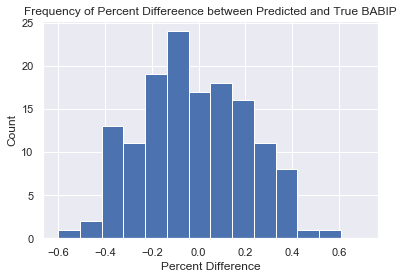

In [30]:
# Plot histogram of percent diff. between predicted and true babips
bins = np.linspace(-.6, .7, 15)
plt.hist(x = pct_diff_babip, bins = bins)

# Label axes
plt.ylabel('Count')
plt.xlabel('Percent Difference')
plt.title('Frequency of Percent Differeence between Predicted and True BABIP')

# Print plot to pdf
file = f'percent_diff_hist_2020.pdf'
with PdfPages(file) as pdf:
    pdf.savefig(bbox_inches='tight')

The histogram above shows the distribution of percent differences between predicted and true BABIPs, where a positive percent difference indicates that the predicted BABIP was greater than the true BABIP. 

We ovsbserve a relatively normal distribution centered slightly below 0.0, again indicating that our predicted BABIPs tended to be lower than the true BABIPs. 

### Classifying Players' BABIP as Above, Below, or As Expected
Using `pct_diff`, we classify each player's BABIP as above, below, or as expected. To account for our model's tendency to predict lower BABIPs, we compare each player's `pct_diff` to the mean `pct_diff` accross all players. We then arbitrarily classify players as follows:
- `below_true`: the player's `pct_diff` is less than the mean `pct_diff` - 1/2 the standard deviation of `pct_diff`, indicating that the player's true babip is ***above expected***
- `above_true`: the player's `pct_diff` is greater than the mean `pct_diff` + 1/2 the standard deviation of `pct_diff`, indicating that the player's true babip is ***below expected***
- `true`: the player's `pct_diff` is greater than or equal to the mean `pct_diff` 1/2 the standard deviation of `pct_diff` and less than or equal tothe mean `pct_diff` + 1/2 the standard deviation of `pct_diff`, indicating that the player's true babip is ***as expected***

In [31]:
def classify_babip_pred(babip_pct_diff, mean, stdev):
    ''' Classifies a player's expected BABIP as above, below, or similar to his true BABIP
    
    Args:
        babip_pct_diff (float): percent difference between player's predicted and true babip
        mean (float): average percent difference between all players' predicted and true babip 

    '''

    if babip_pct_diff < mean - (stdev / 2):
        return 'below_true'
    elif babip_pct_diff < mean + (stdev / 2):
        return 'true'
    else:
        return 'above_true'
    
    

In [32]:
# Compute mean percent difference
pct_diff_mean = np.mean(df_pred_babip_pa['pct_diff'])
pct_diff_stdev = np.std(df_pred_babip_pa['pct_diff'])

# Classify players, add column to dictionary 
df_pred_babip_pa['comp_true'] = df_pred_babip_pa['pct_diff'].apply(classify_babip_pred, args=[pct_diff_mean, pct_diff_stdev])

In [33]:
df_pred_babip_pa.head()

,player,pred_babip,true_babip,pa,pct_diff,comp_true
0,David Peralta,0.354839,0.361290,218,-0.017857,true
1,Carlos Santana,0.283019,0.211538,255,0.337907,above_true
2,Michael Brantley,0.220339,0.335766,187,-0.343773,below_true
3,Eduardo Escobar,0.308824,0.243750,222,0.266968,above_true
4,Marwin Gonzalez,0.268293,0.240602,199,0.115091,above_true


In [34]:
# Count number of players predicted above, below, and similar to true 
df_pred_babip_pa['comp_true'].value_counts()

above_true    50
below_true    48
true          44
Name: comp_true, dtype: int64

## Random Forest Classifier
Once classifying 2020 hitters based on their true and predicted BABIPs, we wish to determine which underlying statistics and tendancies of hitters might make them more likely to over or udner perform with respect to BABIP. 

To do so, we train a Random Forrest Classifier on chosen features for each 2020 batter to attempt to classify them. If successful, we will use feature importance to determine how strongly these features lead to over or under performing. 

In [35]:
df_custom_2020.columns

Index(['Unnamed: 0', 'index', 'Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI',
       'SB', 'BB%', 'K%', 'ISO', 'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'xwOBA',
       'wRC+', 'BsR', 'Off', 'Def', 'WAR', 'LD%', 'GB%', 'FB%', 'IFFB%',
       'HR/FB', 'IFH%', 'BUH%', 'EV', 'LA', 'Barrels', 'Barrel%', 'maxEV',
       'HardHit', 'HardHit%', 'playerid'],
      dtype='object')

In [36]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Set the features we wish to investigate 
x_feat_list = ['K%', 'BB%', 'GB%', 'FB%', 'HR/FB', 'ISO']

In [37]:
# Add above_expected classification
classifications = []

# For each player, add classification to list 
for idx, player in df_custom_2020.iterrows():
    if (player['Name'] == 'A.J. Pollock'):
        name = 'AJ Pollock'
    else:
        name = player['Name']
        
    # Get current player's row in df_pred_babip_pa
    bool_player = df_pred_babip_pa['player'] == name
    df_pred_babip_pa_player = df_pred_babip_pa.loc[bool_player,:]
    
    # Add the player's classification to classifications
    #display(df_pred_babip_pa_player)
    #print(df_pred_babip_pa_player['comp_true'].iloc[0])
    classifications.append(df_pred_babip_pa_player['comp_true'].iloc[0])

In [38]:
# Add classifications as a column in df_custom_qual_2020
df_custom_2020['comp_true'] = classifications
df_custom_2020.head()

,Unnamed: 0,index,Name,Team,G,PA,HR,R,RBI,SB,...,BUH%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,playerid,comp_true
0,0,7,Juan Soto,WSN,47,196,13,39,37,6,...,0.0%,92.1,4.2,22.0,0.175,113.3,65.0,51.6%,20123,below_true
1,1,11,Freddie Freeman,ATL,60,262,13,51,53,2,...,0.0%,92.4,17.2,26.0,0.147,109.3,96.0,54.2%,5361,above_true
2,2,12,Marcell Ozuna,ATL,60,267,18,38,56,0,...,0.0%,93.0,16.4,26.0,0.154,115.6,91.0,53.8%,10324,above_true
3,3,16,DJ LeMahieu,NYY,50,216,10,41,27,3,...,0.0%,91.3,2.3,5.0,0.029,109.5,80.0,45.7%,9874,true
4,4,22,Jose Ramirez,CLE,58,254,17,45,46,10,...,100.0%,88.7,23.2,18.0,0.102,114.3,62.0,35.0%,13510,below_true


#### Random Forest Classifier

In [39]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# extract data
x = df_custom_2020.loc[:, x_feat_list].values
y = df_custom_2020.loc[:, 'comp_true']

# build rf classifier
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(x,y)

RandomForestClassifier()

In [40]:
# Display feature importances
rf_clf.feature_importances_

array([0.1796023 , 0.15126211, 0.16094938, 0.17289658, 0.1741265 ,
       0.16116313])

We perform 10-fold cross validation on the Random Forest Classifier to determine how accurately it classifies unseen players. 

In [41]:
# 10 fold cross validation 
kfold = StratifiedKFold(n_splits=10)

# extract data
x = df_custom_2020.loc[:, x_feat_list].values
y = df_custom_2020.loc[:, 'comp_true']


# initialize an empty array same size as y
y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_true_train = y[train_idx]

    # get testing data
    x_test = x[test_idx, :]
    y_true_test = y[test_idx]

    # create classifier
    rf_clf = RandomForestClassifier(max_depth=3)
    
    # train on training data
    rf_clf.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = rf_clf.predict(x_test)

/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/jdunlevy/opt/anaconda3/lib/python3.7/_collections_abc.py:

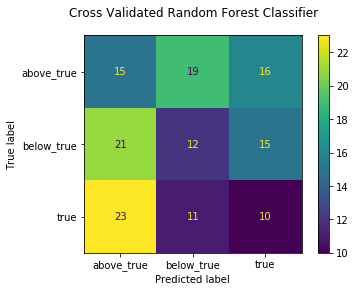

In [42]:
# plot confusion matrix for random forest classifier
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)

# plot confusion matrix
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))

sns.reset_orig()
conf_mat_disp.plot()
plt.suptitle('Cross Validated Random Forest Classifier ')
plt.show()

In [43]:
accuracy = conf_mat.diagonal().sum() / conf_mat.sum()
accuracy

0.2605633802816901

From the confusion matrix, we see that the Random Forest Classifier is not able to accurately classify players as likely to meet, exceed, or fail expecations with regards to BABIP. Thus, the feature importances as determined by the classifier are not meaningful. 

# Discussion

After scatter plotting batted ball events by `exit_velo` and `launch_angle` by hit type, we noticed strong relationships between the two features and the result, which was expected. However, it was surprising to see how differentiated the hits and outs were, reaffirmed by the K-NN Classifier being able to relatively accurately predict hits and outs. 

Our model is able to correctly classify whether or not a batted ball from the 2020 season would result using the 3-NN Classifier trained on 2019 batted ball results. By analyzing our confusion matrices produced after 10-fold cross validation on 2019 game logs and predicting 2020 batted ball results on a 3-NN Classifier, we saw that the classifier correctly classified batted balls about 76% of the time. In this case, a less than perfect classifier is preferred, as it speaks to the random nature of baseball that motivated our problem in the first place. There is no doubt that a strong exit velocity and launch angle are great (and perhaps the most important) indicators of whether or not a batted ball will result in a hit. However, we believe that the 24% of incorrect predictions indicate that there is more that goes into BABIP. 


Because hits and outs are able to be classified based on exit velocity and launch angle and because of this, we were able to compute each player’s expected BABIP based on their 2020 batted ball results, and classify them as above, below, or close to their true BABIP. However, we were unable to expand upon these findings by determining which underlying statistics might contribute to players over or under performing with respect to BABIP. This is because our Random Forest Classifier trained on selected statistics was unable to properly classify players. 

This is not to say definitively that a player's likelihood to accumulate a BABIP above or below expected is purely based on luck. In future studies, models could be trained with different numbers of nearet neighbors in order to maximize accuracy. Furthermore, a more careful selection of statistics used as features in a Random Forest Classifier might lead to more accurate classifications. Other methods might involve regressions on multiple year-long statistics in order to predict BABIP, rather than predicting each individual batted ball event. 

One potential problem with our method is that by predicting the result of each batted ball event for each player, we make a large number of predictions on an imperfect model. This means that error is likely to pile up quickly, potentially skewing our results. 

## Takeaway
The result of this project showed that launch angles and exit velocities are important for getting base hits, though they do not tell the whole story. Using the information found in this project, a few actions could be taken. First, further study into the exact ideal ranges of `exit_velo` and `launch_angle` could provide further insight into how players can maximize hits. 

Coaches and managers can use these models for predicting BABIP to find players that possess the offensive tendencies that are favorable for getting hits on balls put into play, specifically with regards to launch angle and exit velocity. Players can also change their approaches when hitting or their swings to produce hit balls with a favorable launch angle, a trend that has become popular in recent years. 

The main question that needs to be answered is whether or not there are other outlying factors that contribute to BABIP. There was an attempt to check the feature importance of traditional statistics but there are definitely more factors than that go into hitting. Does the approach of opposing pitchers affect how a hitter swings during his at-bats? How is the defense lined up when different batters come up to the plate, and does that change his approach? Baseball is a game of many dimensions and just looking it from a hitter’s perspective definitely does not show the whole story. Considering all of these factors, it is not surprising that feature importances for statistics like walk and strikeout rate, line drive percentage, and home run to fly ball ratio were not able to be determined.

Finally, there may be too much randomness in baseball to make an accurate prediction or model. Furhermore, there are pleanty of other factors that make players valuable to teams besides BABIP. Just like in any other sport, there are different types of players that can all add value to a baseball team in different ways: power hitters are able to drive in runners and put runs on the board in a big way, contact hitters get on base often and keep the lineup moving, and some players might be starting just because of their defense. 